# Graph Setup and imports

The following code re-loads & rebuilds the graph from the previous notebooks. See Weighted Graph analysis (Notebook 4).

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import warnings
# import scipy.stats as stats
import random # NEW!
from collections import defaultdict # NEW!
warnings.filterwarnings('ignore', category=UserWarning)
# Set seeds for BOTH random number generators (we use both libraries)
np.random.seed(99) # Set random seed for reproducibility
random.seed(99) # NEW!
df = pd.read_csv('../data/bilat_mig_40_countries.csv')# Load the migration data
# Rebuild the directed graph
G = nx.DiGraph()
for index, row in df.iterrows():
    if row['da_pb_closed'] > 0:
        G.add_edge(row['orig'], row['dest'], weight=row['da_pb_closed'])
print("Libraries loaded and graph rebuilt successfully!")
print(f"Graph: {G.number_of_nodes()} countries, {G.number_of_edges()} migration flows")

Libraries loaded and graph rebuilt successfully!
Graph: 40 countries, 1408 migration flows


# Map Graphing
## Initial Imports

Added imports required for mapping. The world map and associated information can be acquired from the natural earth dataset:\
https://www.naturalearthdata.com/downloads/110m-cultural-vectors/110m-admin-0-countries

NOTE: There is a known issue that france and other countries have no ISO code.\
This has been manually corrected for affected countries\
https://github.com/geopandas/geopandas/issues/1041

In [118]:
import geopandas as gpd
# pip install geopandas


# Get World Basemap (For map)
url_basemap = "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"
basemap = gpd.read_file(url_basemap)

# Get World Shapefile (For country coordinates)
url_world_shp = "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"
world_shp = gpd.read_file(url_world_shp)

# Incorrect ISO Codes in source
world_shp.loc[world_shp["NAME"] == 'France',    'ISO_A3'] = 'FRA'
world_shp.loc[world_shp["NAME"] == 'Hong Kong', 'ISO_A3'] = 'HKG'

## Country Centroids
Later display methods expect lat/lon coordinates for labels..\
Currently, we only have 3-letter ISO country codes, as seen previously.

The country datase extracted from Natural Earth allows retrieving centerpoints for each country from ISO code.

In [119]:

def retrieve_country_centroid(ISO_Code, world_shp):
    """
    Params:
        ISO_Code: A 3-letter ISO country code, e.g. "AUS"
        world_shp: A world shapefile from geopandas
    Returns:
        Coordinates for centerpoint of that country
    """

    # Find which country row matches the ISO name
    country_match = world_shp.index[world_shp["ISO_A3"] == ISO_Code]

    if(len(country_match) == 0):
        # No Match
        print("Retrieving centroid for", ISO_Code, "NO MATCH")
        return [0,0]
    
    country_id = country_match.tolist()[0]

    # Retrieve Centroid
    centroid = world_shp.geometry.centroid[country_id]
    coord = [centroid.x, centroid.y]

    print("Retrieving centroid for", ISO_Code + ", row", country_id, "-", coord)

    return coord


# Retrieve Centroid for all Countries
country_list = list(G.nodes())
centroid_coords_x = []
centroid_coords_y = []

for country in country_list:
    coord = retrieve_country_centroid(country, world_shp)
    centroid_coords_x.append(coord[0])
    centroid_coords_y.append(coord[1])


# Create Dataframe from coords
centroid_df = pd.DataFrame()
centroid_df["country"] = country_list
centroid_df["x"] = centroid_coords_x
centroid_df["y"] = centroid_coords_y


Retrieving centroid for UGA, row 168 - [32.35755031998686, 1.2954855035097297]
Retrieving centroid for SSD, row 176 - [30.198617582461907, 7.292890133516845]
Retrieving centroid for EGY, row 163 - [29.844461513124415, 26.50661999974957]
Retrieving centroid for SDN, row 14 - [29.862604012257922, 15.990585003116717]
Retrieving centroid for ZAF, row 25 - [25.048013879861678, -28.947033259979115]
Retrieving centroid for CIV, row 60 - [-5.6120436452252225, 7.5537550070104915]
Retrieving centroid for NGA, row 56 - [7.995127754089786, 9.548318418209965]
Retrieving centroid for CHN, row 139 - [103.88361230063249, 36.555066531858685]
Retrieving centroid for JPN, row 155 - [138.06496213270776, 37.66311081170466]
Retrieving centroid for IDN, row 8 - [117.42340756227364, -2.221737936520542]
Retrieving centroid for MYS, row 148 - [109.6981484486297, 3.7255884257737155]
Retrieving centroid for BGD, row 99 - [90.26792827719598, 23.83946179534406]
Retrieving centroid for IND, row 98 - [79.593703763253

## Map Display
We now have all the necessary data to plot into a world map.

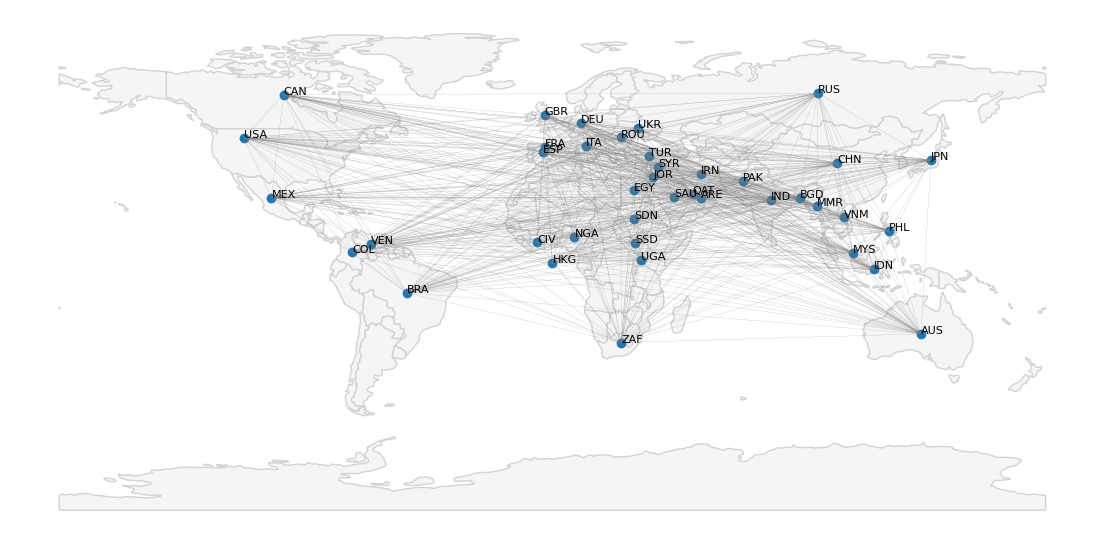

In [120]:
# Plot World Map
fig, ax = plt.subplots(figsize=(14, 7))
world.plot(ax=ax, color="whitesmoke", edgecolor="lightgray")
ax.set_axis_off()


ax.scatter(centroid_df["x"], centroid_df["y"])

for i, row in centroid_df.iterrows():
    ax.text(row["x"], row["y"], row["country"], fontsize=8, color="black")


# Plot Pairs
for country1, country2 in G.edges():
    country1_df = centroid_df.loc[centroid_df["country"] == country1]
    country2_df = centroid_df.loc[centroid_df["country"] == country2]

    x = [country1_df["x"], country2_df["x"]]
    y = [country1_df["y"], country2_df["y"]]
    ax.plot(x, y, color="gray", alpha=0.5, linewidth=0.1)

plt.show()